# Empirical Pipeline in Python: VAR, VECM, and AR–GARCH with VaR/ES Backtesting

This notebook implements a complete empirical pipeline to analyse macroeconomic time series and equity returns using VAR, VECM, and AR(p)–GARCH models. It documents each step from data collection and transformation through exploratory analysis, formal testing, modelling, forecasting, risk management, and backtesting. The data are drawn from FRED for monthly macro variables and from Yahoo Finance for daily equity prices. Rolling in-sample and out-of-sample evaluations at a 70/30 split ensure robust assessment. The models are estimated in Python using free libraries only.


In [3]:
# Environment setup and reproducibility
import sys, json, warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import scipy
from scipy import stats
from pandas_datareader import data as pdr
import yfinance as yf

from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
from statsmodels.stats.stattools import jarque_bera
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.vector_ar.vecm import VECM, coint_johansen

from arch.univariate import arch_model

# Fix random seed for reproducibility
np.random.seed(42)

# Configuration dictionary stored in memory
CONFIG = {
    'train_frac': 0.70,
    'macro_start': '1985-01-01',
    'macro_series': {
        'INDPRO': {'name': 'Industrial Production Index', 'transform': 'log'},
        'CPIAUCSL': {'name': 'CPI All Urban Consumers', 'transform': 'log'},
        'UNRATE': {'name': 'Unemployment Rate', 'transform': 'level'},
        'FEDFUNDS': {'name': 'Effective Fed Funds Rate', 'transform': 'level'},
        'DTWEXBGS': {'name': 'Trade Weighted U.S. Dollar Index (Broad)', 'transform': 'log'}
    },
    'equity_start': '2005-01-01',
    'equity_tickers': ['AAPL', 'MSFT', 'AMZN', 'GOOGL', 'JPM'],
    'var_max_lags': 12,
    'vecm_max_lags': 12,
    'ar_max_lags': 5,
    'alpha_levels': [0.01, 0.025, 0.05],
    'var_horizons': [1, 3, 6, 12]
}

# Capture version info for reproducibility
VERSIONS = {
    'python': sys.version,
    'numpy': np.__version__,
    'pandas': pd.__version__,
    'matplotlib': plt.matplotlib.__version__,
    'scipy': scipy.__version__,
    'statsmodels': __import__('statsmodels').__version__,
    'arch': __import__('arch').__version__,
    'pandas_datareader': __import__('pandas_datareader').__version__,
    'yfinance': yf.__version__
}
print(json.dumps(VERSIONS, indent=2))


{
  "python": "3.13.5 | packaged by Anaconda, Inc. | (main, Jun 12 2025, 16:37:03) [MSC v.1929 64 bit (AMD64)]",
  "numpy": "2.1.3",
  "pandas": "2.2.3",
  "matplotlib": "3.10.0",
  "scipy": "1.15.3",
  "statsmodels": "0.14.4",
  "arch": "8.0.0",
  "pandas_datareader": "0.10.0",
  "yfinance": "0.2.66"
}


**Scope and hypotheses**: This study assesses dynamic relationships among several monthly U.S. macroeconomic indicators and evaluates volatility and risk in selected U.S. equities. Hypotheses include whether macro variables follow unit-root or stationary processes, whether they are cointegrated, and how well various models forecast future values and risks.

**Variables and sample windows**: Target macro variables include industrial production, consumer price index, unemployment rate, effective federal funds rate and broad trade-weighted dollar index. Equity returns are drawn from five large U.S. companies. The initial in-sample window uses 70\% of available observations, and the remaining 30\% form an out-of-sample evaluation via a rolling window.

**Reproducibility**: A fixed random seed and explicit version reporting ensure reproducibility. The entire workflow is contained in this single notebook, without external configuration files.


## Mathematical Notation: Unit Root and Diagnostic Tests

### Augmented Dickey–Fuller (ADF) Test
The ADF regression for a univariate series $y_t$ with lag order $p$ is
$$\
\Delta y_t = \mu + \phi t + \gamma y_{t-1} + \sum_{i=1}^{p} \psi_i \Delta y_{t-i} + \varepsilon_t,\quad \varepsilon_t \sim \mathcal{N}(0, \sigma^2)\
$$
The null hypothesis of a unit root is $H_0:\gamma=0$. Rejection implies stationarity.

### KPSS Test
For $y_t = \xi_t + \epsilon_t$ with random walk component $\xi_t$, the KPSS statistic is
$$\
\text{KPSS} = \frac{1}{T^2 \hat{\sigma}_\epsilon^2} \sum_{t=1}^T S_t^2,\quad S_t = \sum_{i=1}^t \hat{u}_i\
$$
where $\hat{u}_i$ are residuals from regressions on deterministic components. The null hypothesis is stationarity.

### Jarque–Bera Test
The Jarque–Bera test statistic for normality of a sample of size $T$ with skewness $S$ and kurtosis $K$ is
$$\
\text{JB} = \frac{T}{6}\Big( S^2 + \frac{(K-3)^2}{4} \Big)\
$$
Under the null of normality, JB is asymptotically $\chi^2_2$.

### Ljung–Box Test
For residuals $\hat{\varepsilon}_t$ and autocorrelations $\hat{\rho}_k$, the Ljung–Box statistic at lag $m$ is
$$\
Q(m) = T(T+2) \sum_{k=1}^{m} \frac{\hat{\rho}_k^2}{T-k}\
$$
which under the null of no serial correlation follows $\chi^2_m$.

### ARCH–LM Test
For squared residuals $\hat{\varepsilon}_t^2$, regress on a constant and $q$ lags:
$$\
\hat{\varepsilon}_t^2 = \alpha_0 + \sum_{i=1}^q \alpha_i \hat{\varepsilon}_{t-i}^2 + u_t.\
$$
The Lagrange multiplier statistic $LM = T R^2$ is asymptotically $\chi^2_q$ under $H_0$ of no ARCH effects.


## Mathematical Notation: System Models, Volatility and Risk Measures

### VAR($p$) Model
For a $k$-dimensional vector $y_t$ and lag order $p$:
$$\
y_t = c + \sum_{i=1}^p A_i y_{t-i} + u_t,\quad u_t \sim \mathcal{N}_k(0, \Sigma_u).\
$$

### Johansen Cointegration Tests
For $k$-dimensional I(1) variables in VAR form, the Johansen trace statistic for rank $r$ is
$$\
\text{Trace}(r) = -T \sum_{i=r+1}^k \ln(1 - \hat{\lambda}_i),\
$$
and the maximum eigenvalue statistic is
$$\
\text{MaxEig}(r, r+1) = -T \ln(1 - \hat{\lambda}_{r+1}),\
$$
where $\hat{\lambda}_i$ are estimated eigenvalues.

### VECM
If cointegration rank is $r$, the Vector Error Correction Model (VECM) is
$$\
\Delta y_t = \Pi y_{t-1} + \sum_{i=1}^{p-1} \Gamma_i \Delta y_{t-i} + c + \varepsilon_t,\quad \Pi = \alpha \beta',\
$$
with $\beta$ containing cointegration vectors and $\alpha$ adjustment speeds.

### AR($p$)–GARCH(1,1) Model with Normal Innovations
For returns $r_t$:
$$\
r_t = \mu + \sum_{i=1}^p \phi_i r_{t-i} + \varepsilon_t,\quad \varepsilon_t = \sigma_t z_t,\ z_t \sim \mathcal{N}(0,1),\
$$
with conditional variance
$$\
\sigma_t^2 = \omega + \alpha \varepsilon_{t-1}^2 + \beta \sigma_{t-1}^2,\quad \omega>0,\ \alpha,\beta \ge 0,\ \alpha+\beta < 1.\
$$

### VaR and ES under Normality
With one-step forecasted mean $\hat{\mu}_{t+1}$ and volatility $\hat{\sigma}_{t+1}$, the Value at Risk (VaR) at level $\alpha$ is
$$\
\text{VaR}_{\alpha,t+1} = -\hat{\mu}_{t+1} + \hat{\sigma}_{t+1}\, \Phi^{-1}(1-\alpha),\
$$
and the Expected Shortfall (ES) is
$$\
\text{ES}_{\alpha,t+1} = -\hat{\mu}_{t+1} + \hat{\sigma}_{t+1}\, \frac{\phi\big(\Phi^{-1}(1-\alpha)\big)}{\alpha},\
$$
where $\Phi$ and $\phi$ are the standard normal CDF and PDF.

### VaR Backtests
Let indicator $I_t = \mathbb{1}\{ r_t < -\text{VaR}_{\alpha,t} \}$ and total violations $x=\sum I_t$ in $N$ forecasts.
* **Kupiec POF** statistic is
$$\
LR_{\text{POF}} = -2\Big[ \ln\big((1-\alpha)^{N-x} \alpha^{x}\big) - \ln\big((1-\hat{p})^{N-x} \hat{p}^{x}\big) \Big],\quad \hat{p} = x/N,\
$$
which is $\chi^2_1$ under the null of correct unconditional coverage.
* **Christoffersen independence** test uses transitions $n_{ij}$ from states $i$ to $j$ in violations to form an LR statistic for independence.
* **Conditional coverage** combines POF and independence: $LR_{\text{CC}} = LR_{\text{POF}} + LR_{\text{IND}} \sim \chi^2_2$.

### ESR Test for ES
A simplified Acerbi–Székely (ESR) test examines the mean of a strictly consistent scoring function for ES. Let losses be $\ell_t = -r_t$ and forecasts $\text{VaR}_{\alpha,t}$, $\text{ES}_{\alpha,t}$. Define scores
$$\
S_t = \frac{1}{\alpha}\big( ( \ell_t - \text{VaR}_{\alpha,t} ) \mathbb{1}\{ \ell_t > \text{VaR}_{\alpha,t} \} + \text{VaR}_{\alpha,t} - \text{ES}_{\alpha,t} \big).\
$$
Under the null of correctly specified ES, the sample mean of $S_t$ should be zero. A t-test on $\bar{S}$ is used to assess significance.

### Diebold–Mariano (DM) Test
For comparing two forecast loss series $d_t = L_{1,t} - L_{2,t}$, the DM statistic is
$$\
\text{DM} = \frac{\bar{d}}{\sqrt{ \widehat{\text{Var}}(\bar{d}) }},\
$$
which is approximately standard normal under the null that both forecasts have equal predictive accuracy.


## 1) Data Collection

We obtain monthly macroeconomic time series from the Federal Reserve Economic Data (FRED) database using `pandas_datareader`. The selected series are:

* **INDPRO** – Industrial Production Index (log-transformed).
* **CPIAUCSL** – Consumer Price Index for All Urban Consumers (log-transformed).
* **UNRATE** – Unemployment Rate (level).
* **FEDFUNDS** – Effective Federal Funds Rate (level).
* **DTWEXBGS** – Trade Weighted U.S. Dollar Index (Broad) (log-transformed).

Daily equity prices are downloaded from Yahoo Finance via the `yfinance` interface for the tickers: AAPL, MSFT, AMZN, GOOGL, and JPM. Only the adjusted closing prices are used to compute returns. The macro data begin in 1985 and the equity data in 2005 to ensure long histories.


In [4]:
# Download monthly macroeconomic series from FRED
macro_data = {}
for code, info in CONFIG['macro_series'].items():
    series = pdr.DataReader(code, 'fred', CONFIG['macro_start'])
    macro_data[code] = series
# Concatenate into single DataFrame
macro_df = pd.concat(macro_data, axis=1)
macro_df.index = pd.to_datetime(macro_df.index)
macro_df.columns = list(CONFIG['macro_series'].keys())
# Display head and tail
print('Macro data shape:', macro_df.shape)
display(macro_df.head())
display(macro_df.tail())


Macro data shape: (5490, 5)


,INDPRO,CPIAUCSL,UNRATE,FEDFUNDS,DTWEXBGS
DATE,,,,,
1985-01-01,54.5270,105.7,7.3,8.35,NaN
1985-02-01,54.6871,106.3,7.2,8.50,NaN
1985-03-01,54.7673,106.8,7.2,8.58,NaN
1985-04-01,54.6467,107.0,7.3,8.27,NaN
1985-05-01,54.7396,107.2,7.2,7.97,NaN


,INDPRO,CPIAUCSL,UNRATE,FEDFUNDS,DTWEXBGS
DATE,,,,,
2025-10-20,NaN,NaN,NaN,NaN,121.0394
2025-10-21,NaN,NaN,NaN,NaN,121.3020
2025-10-22,NaN,NaN,NaN,NaN,121.3075
2025-10-23,NaN,NaN,NaN,NaN,121.3633
2025-10-24,NaN,NaN,NaN,NaN,121.3420


In [ ]:
# Download daily adjusted closing prices for selected equities using yfinance
tickers = CONFIG['equity_tickers']
start_date = CONFIG['equity_start']

equity_prices = yf.download(tickers, start=start_date, auto_adjust=False, progress=False)["Adj Close"]
equity_prices.index = pd.to_datetime(equity_prices.index)
print('Equity price data shape:', equity_prices.shape)
display(equity_prices.head())
display(equity_prices.tail())


Equity price data shape: (5241, 5)


Ticker,AAPL,AMZN,GOOGL,JPM,MSFT
Date,,,,,
2005-01-03,0.949987,2.2260,5.038075,22.368946,18.454887
2005-01-04,0.959744,2.1070,4.834026,22.138391,18.523899
2005-01-05,0.968149,2.0885,4.809422,22.184502,18.482487
2005-01-06,0.968900,2.0525,4.686148,22.311304,18.461792
2005-01-07,1.039447,2.1160,4.817871,22.132631,18.406576


Ticker,AAPL,AMZN,GOOGL,JPM,MSFT
Date,,,,,
2025-10-24,262.820007,224.210007,259.920013,300.440002,523.609985
2025-10-27,268.809998,226.970001,269.269989,304.149994,531.520020
2025-10-28,269.000000,229.250000,267.470001,305.359985,542.070007
2025-10-29,269.700012,230.300003,274.570007,305.510010,541.549988
2025-10-30,NaN,NaN,NaN,309.415009,NaN


## 2) Cleaning and Transformations

The macro series and equity prices are aligned and cleaned prior to analysis. Missing observations in macro series are forward-filled when appropriate and equities are forward-filled then backward-filled to handle non-trading days.

Transformations applied:

* **Macro variables**: Series specified as `log` are transformed using natural logarithms; their first differences (Δlog) are computed to induce stationarity. Series specified as `level` are differenced directly.
* **Equities**: Returns are computed as 100 times the difference of the natural log of adjusted prices, $r_t = 100\,\Delta\log P_t$.

Seasonal adjustment and structural break indicators can be incorporated if known break dates exist, but they are optional and not used here.


In [8]:
# Clean and transform the macro and equity data
# Forward-fill then back-fill any missing macro observations
macro_df_ffill = macro_df.copy().ffill().bfill()
# Apply transformations
macro_trans = pd.DataFrame(index=macro_df_ffill.index)
for code, spec in CONFIG['macro_series'].items():
    series = macro_df_ffill[code]
    if spec['transform'] == 'log':
        macro_trans[code] = np.log(series)
        macro_trans[f'diff_{code}'] = macro_trans[code].diff()
    else:
        macro_trans[code] = series
        macro_trans[f'diff_{code}'] = series.diff()
# Drop initial NaNs created by differencing
macro_diff = macro_trans[[f'diff_{code}' for code in CONFIG['macro_series'].keys()]].dropna()

# Clean equity prices: forward-fill then back-fill for missing days
equity_prices_ffill = equity_prices.copy().ffill().bfill()
# Compute log returns in percent
equity_log = np.log(equity_prices_ffill)
equity_returns = 100 * equity_log.diff().dropna()
print('Transformed macro differenced data shape:', macro_diff.shape)
print('Equity returns data shape:', equity_returns.shape)
display(macro_diff.head())
display(equity_returns.head())


Transformed macro differenced data shape: (5489, 5)
Equity returns data shape: (5240, 5)


,diff_INDPRO,diff_CPIAUCSL,diff_UNRATE,diff_FEDFUNDS,diff_DTWEXBGS
DATE,,,,,
1985-02-01,0.002932,0.005660,-0.1,0.15,0.0
1985-03-01,0.001465,0.004693,0.0,0.08,0.0
1985-04-01,-0.002204,0.001871,0.1,-0.31,0.0
1985-05-01,0.001699,0.001867,-0.1,-0.30,0.0
1985-06-01,-0.000523,0.002795,0.2,-0.44,0.0


Ticker,AAPL,AMZN,GOOGL,JPM,MSFT
Date,,,,,
2005-01-04,1.021789,-5.494110,-4.134443,-1.036039,0.373251
2005-01-05,0.871964,-0.881907,-0.510262,0.208065,-0.223812
2005-01-06,0.077530,-1.738755,-2.596616,0.569954,-0.112032
2005-01-07,7.028266,3.046892,2.772129,-0.804041,-0.299530
2005-01-10,-0.419630,-1.140693,0.622260,-0.339168,0.486218


## 3) Descriptive Statistics

Descriptive statistics help summarise the distributional properties of the transformed series and highlight potential issues such as heavy tails or skewness. Tables of means, medians, standard deviations, skewness, kurtosis and quantiles are computed for both macro differences and equity returns.

Time series plots visualise levels and changes over time. Autocorrelation (ACF) and partial autocorrelation (PACF) plots for differenced macro series and equity returns reveal persistence and lag structures, while ACFs of squared returns indicate volatility clustering. Heatmaps of correlation matrices give an overview of relationships across variables.


Macro differenced statistics:


,mean,median,std,skewness,kurtosis,min,5%,25%,50%,75%,95%,max
diff_INDPRO,0.000117,0.0,0.002953,-19.360919,1048.102205,-0.142045,0.000000,0.000000,0.0,0.000000,0.000943,0.063771
diff_CPIAUCSL,0.000204,0.0,0.001026,2.925813,49.829145,-0.017864,0.000000,0.000000,0.0,0.000000,0.002026,0.013675
diff_UNRATE,-0.000547,0.0,0.155487,53.521253,3662.377493,-2.200000,0.000000,0.000000,0.0,0.000000,0.000000,10.400000
diff_FEDFUNDS,-0.000752,0.0,0.059260,-2.552733,80.241601,-0.960000,0.000000,0.000000,0.0,0.000000,0.000000,0.870000
diff_DTWEXBGS,0.000033,0.0,0.003262,-0.031444,5.069799,-0.025620,-0.005064,-0.001584,0.0,0.001619,0.005186,0.018964


Equity returns statistics:


,mean,median,std,skewness,kurtosis,min,5%,25%,50%,75%,95%,max
Ticker,,,,,,,,,,,,
AAPL,0.107798,0.110827,2.032338,-0.208270,6.082723,-19.747023,-3.050081,-0.828347,0.110827,1.152068,3.206068,14.261749
AMZN,0.088534,0.064502,2.361829,0.330350,12.774747,-24.618155,-3.254308,-0.995276,0.064502,1.227581,3.461936,23.862098
GOOGL,0.076301,0.084634,1.888997,0.235763,7.656204,-12.368464,-2.824314,-0.801297,0.084634,1.006237,2.770122,18.225105
JPM,0.050134,0.050775,2.253519,0.256201,18.135418,-23.227776,-3.003646,-0.795496,0.050775,0.914050,2.877839,22.391691
MSFT,0.064487,0.048980,1.701190,-0.021314,9.525657,-15.945355,-2.507775,-0.713142,0.048980,0.884312,2.497212,17.062521


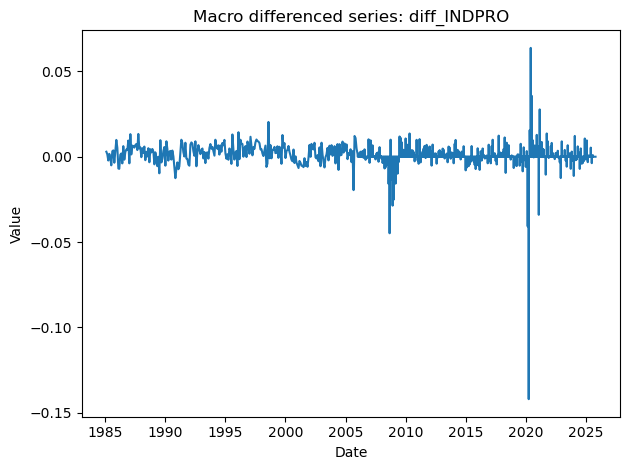

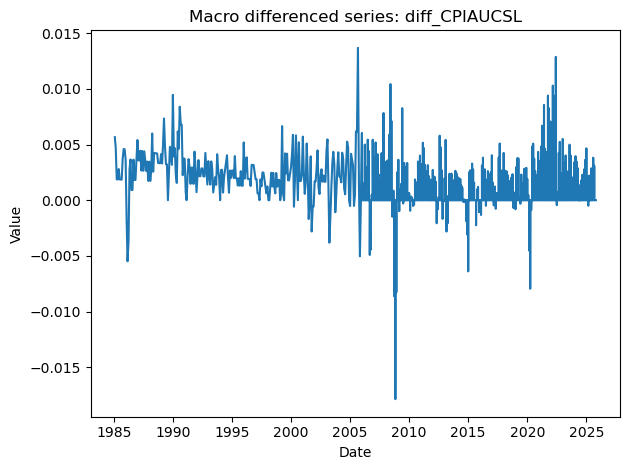

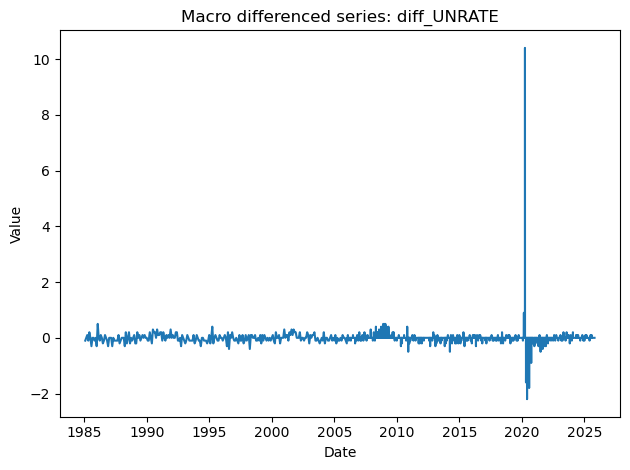

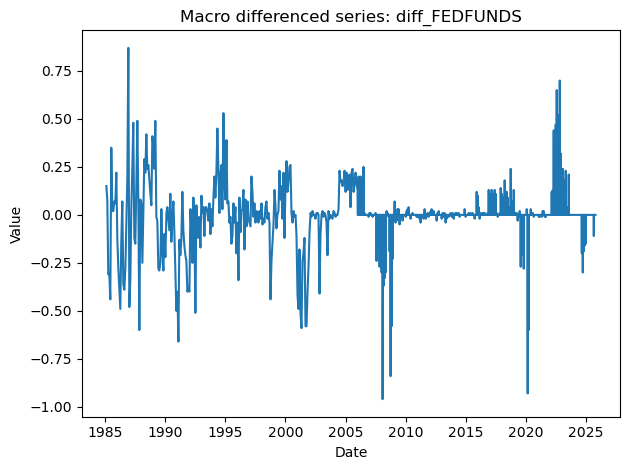

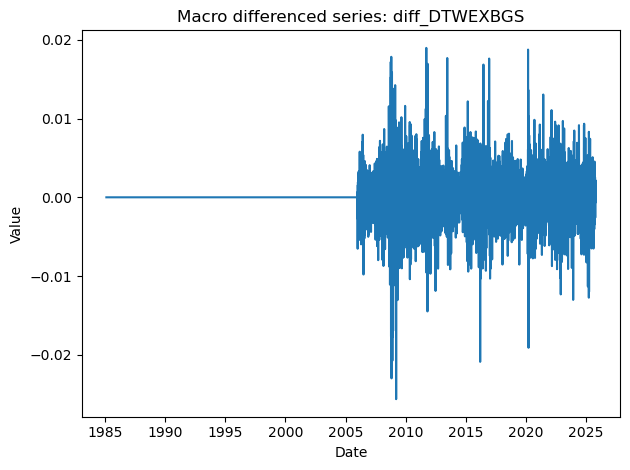

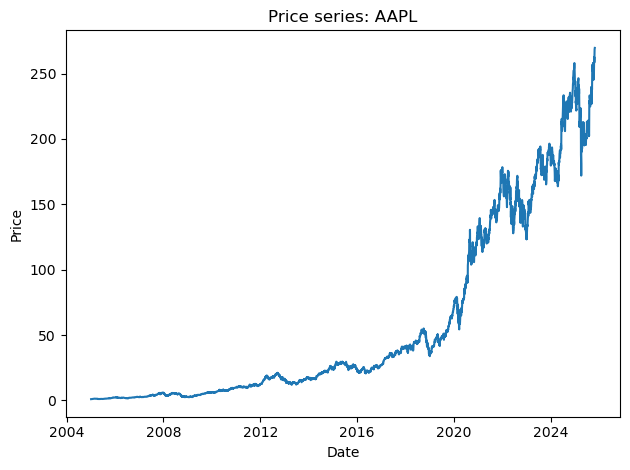

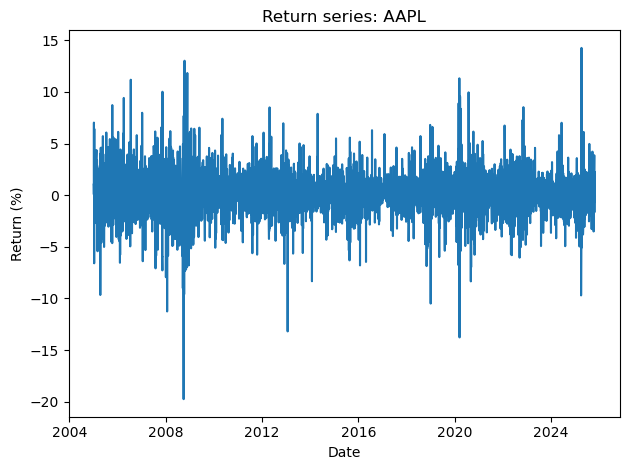

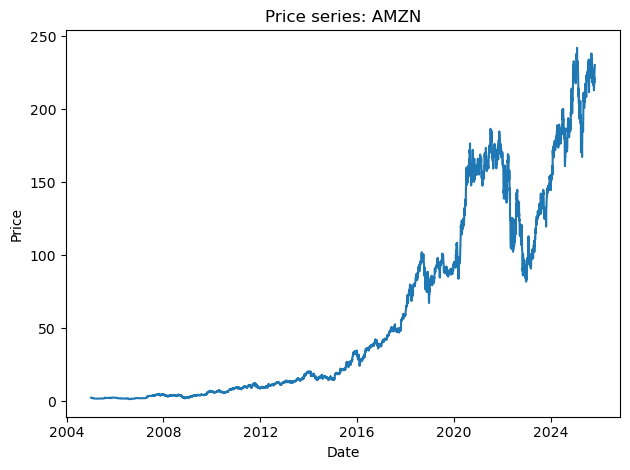

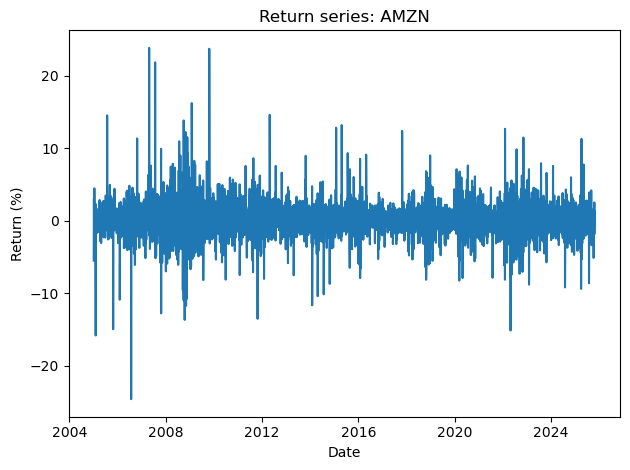

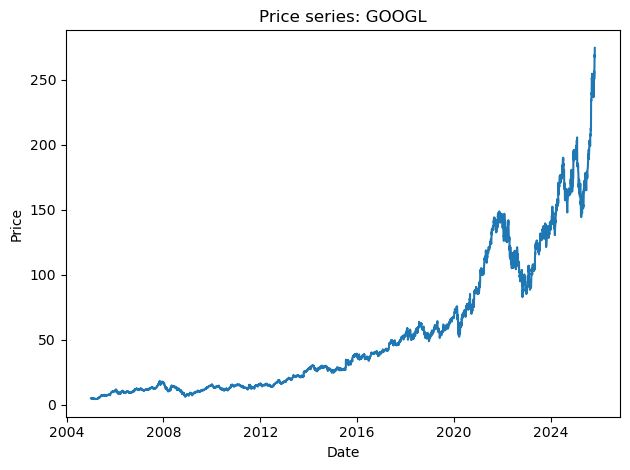

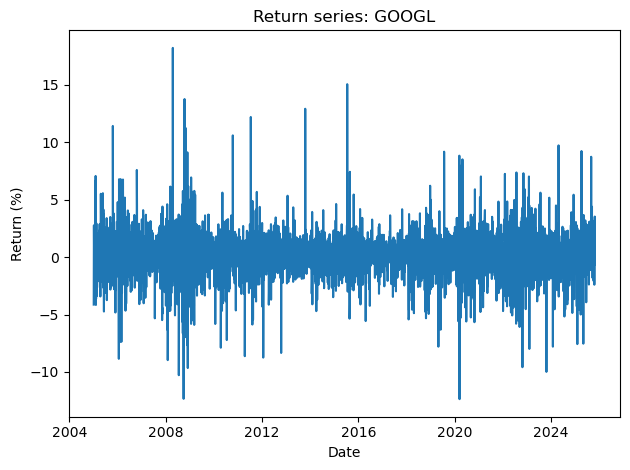

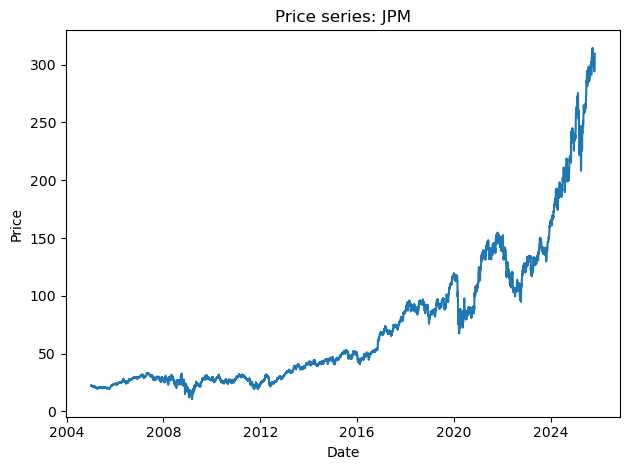

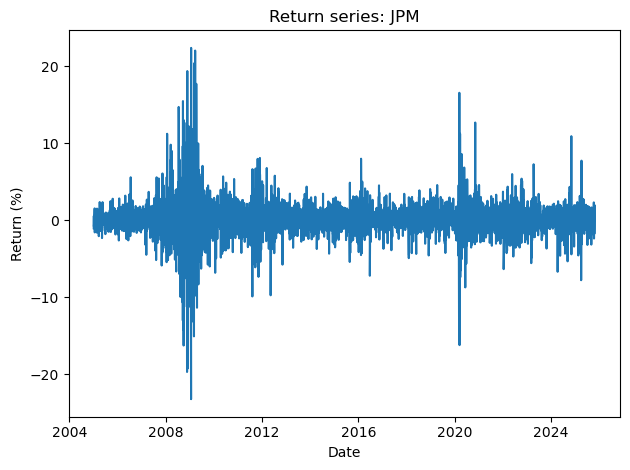

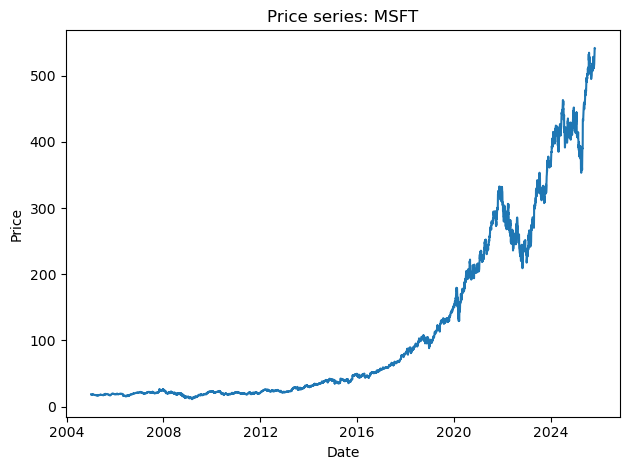

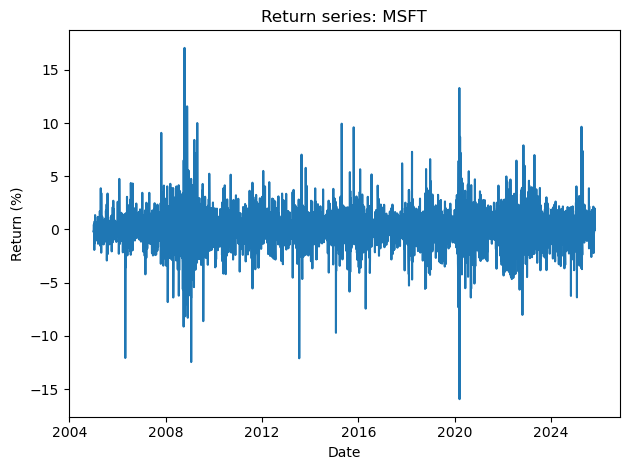

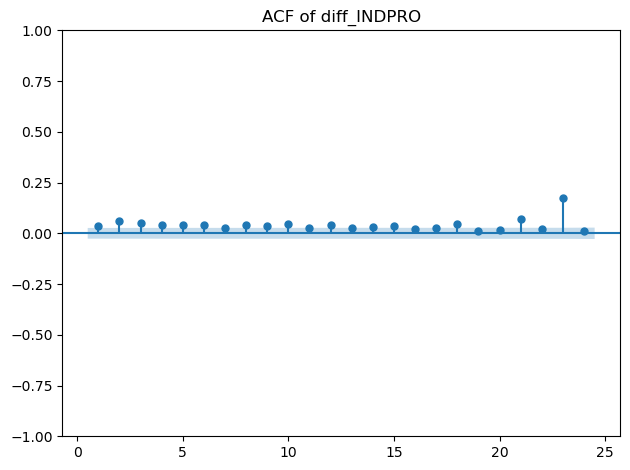

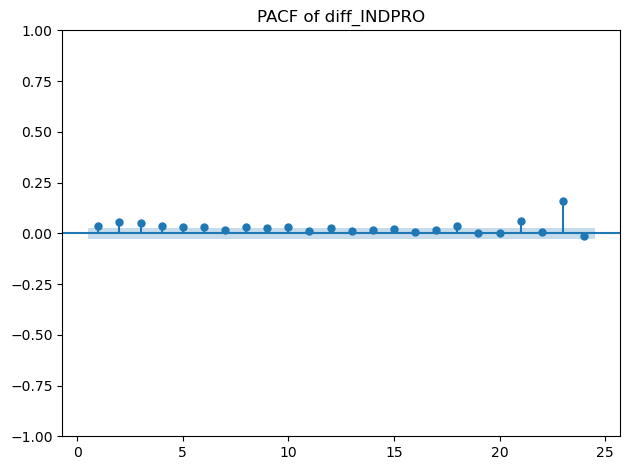

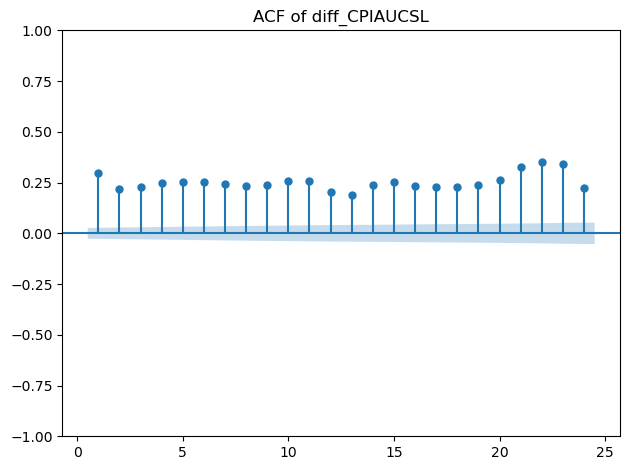

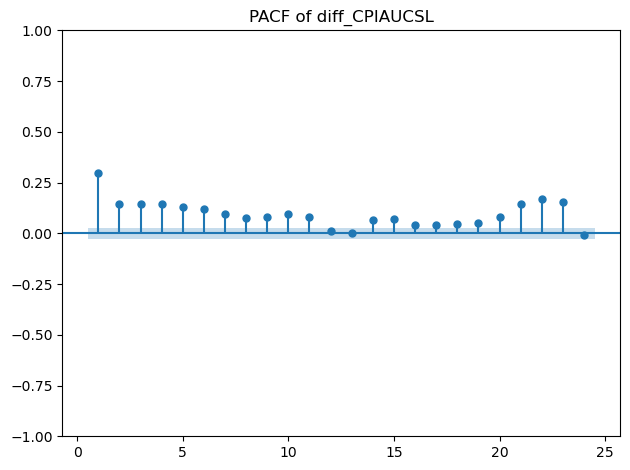

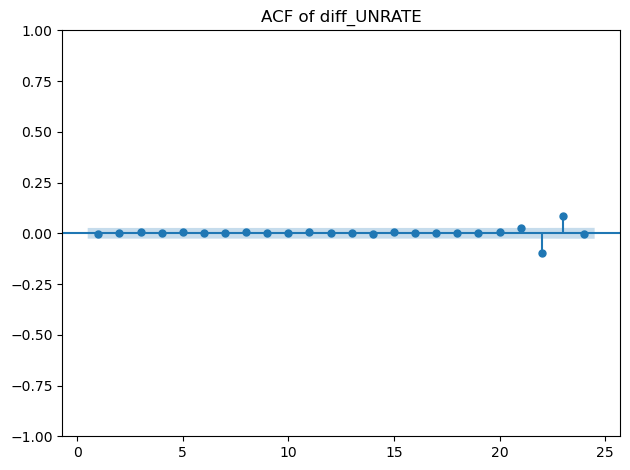

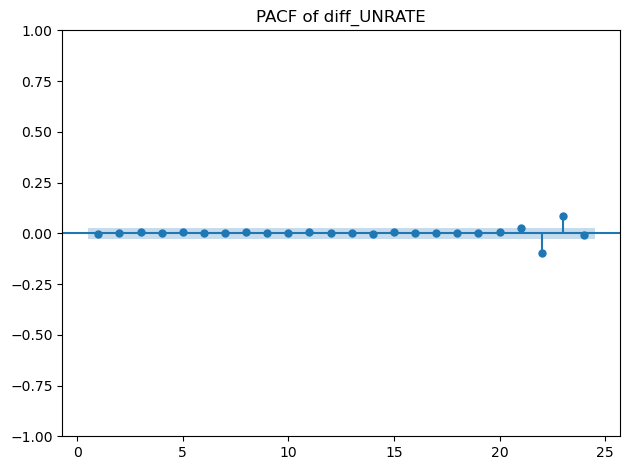

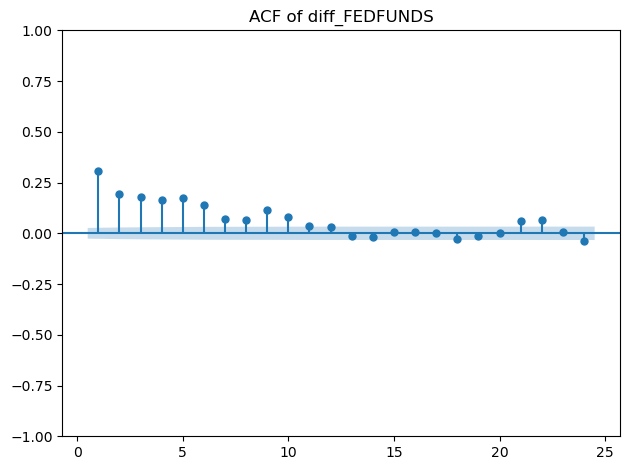

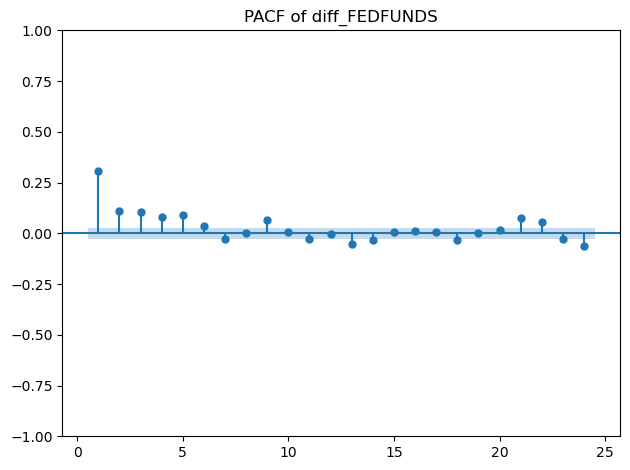

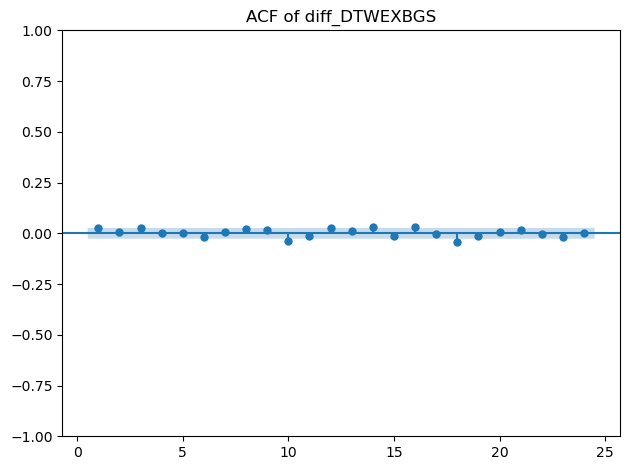

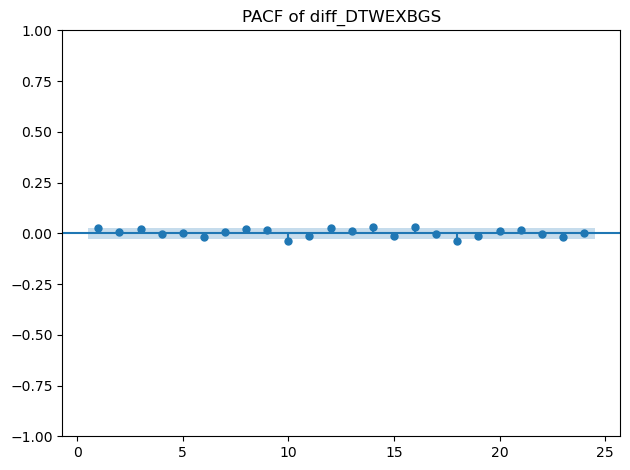

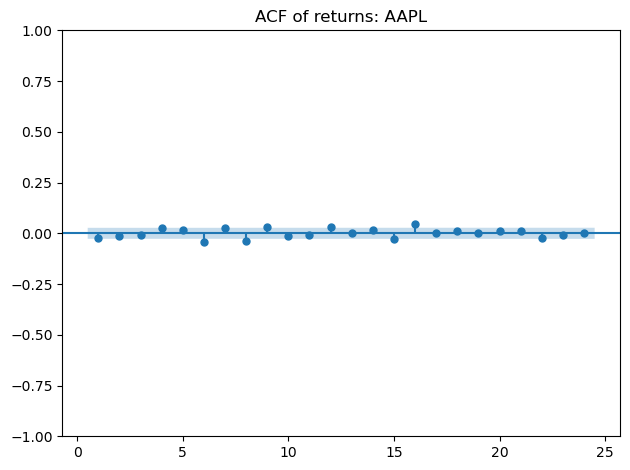

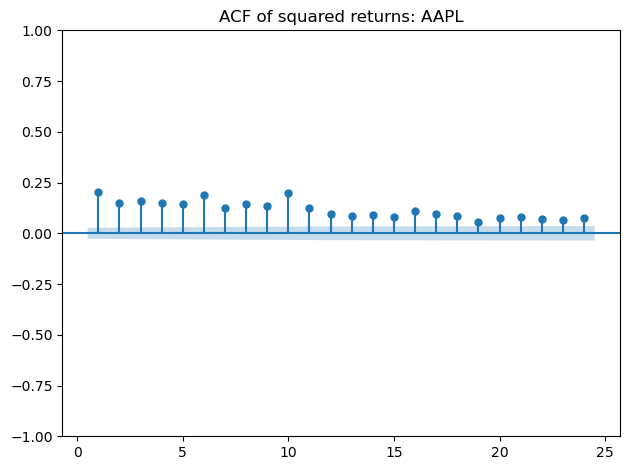

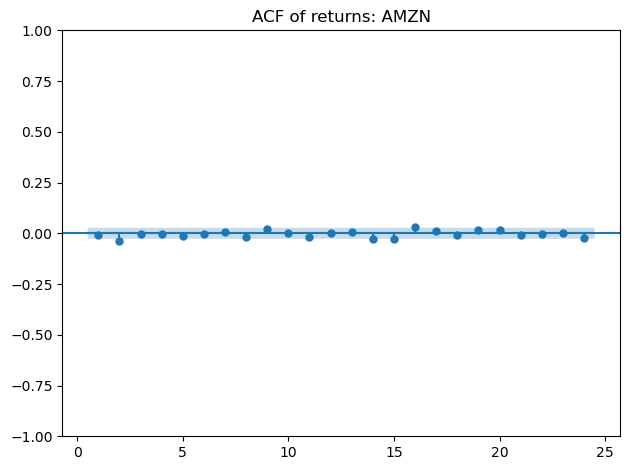

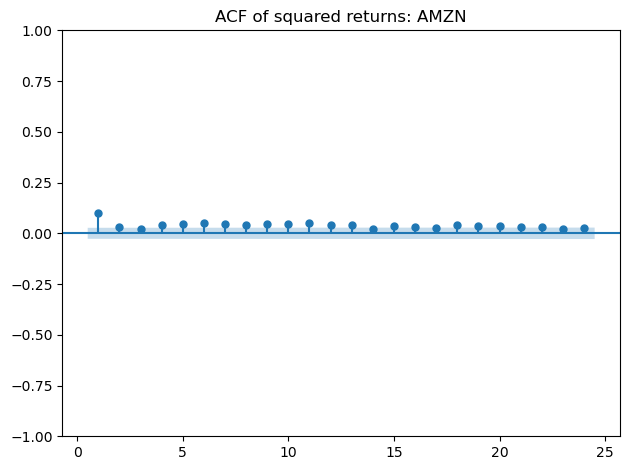

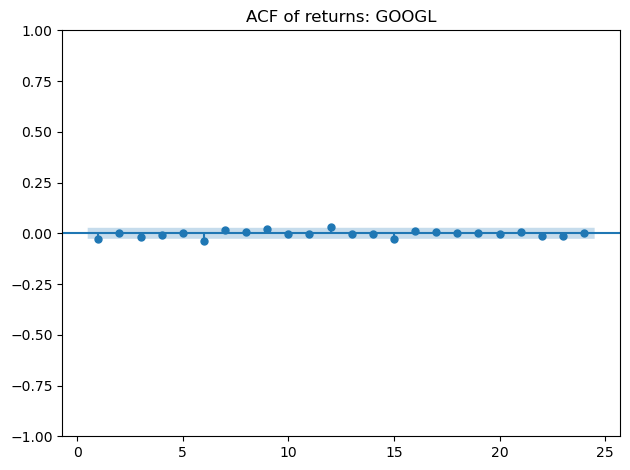

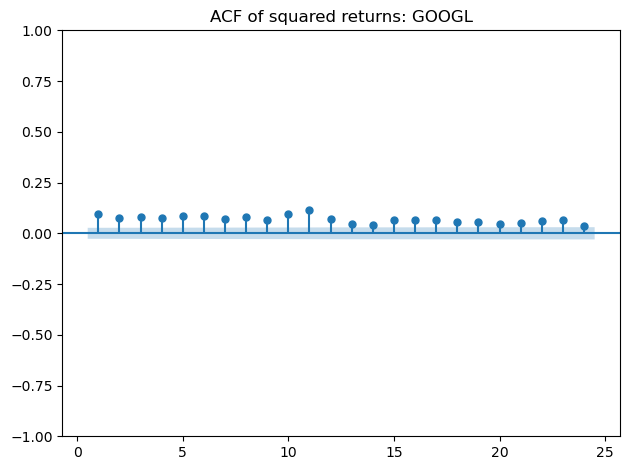

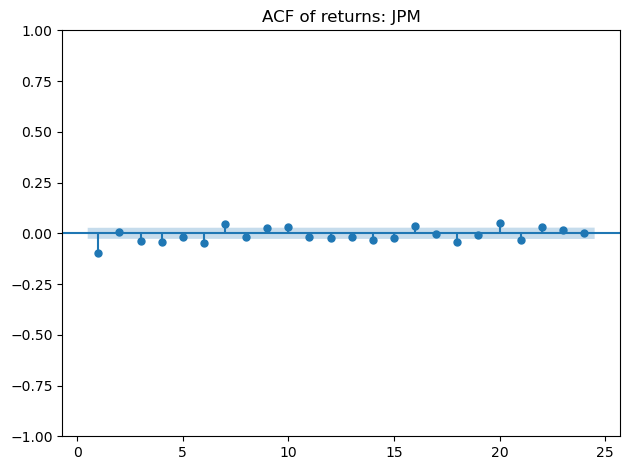

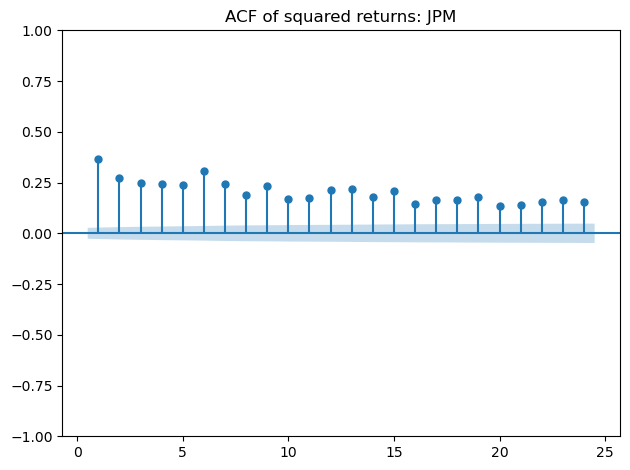

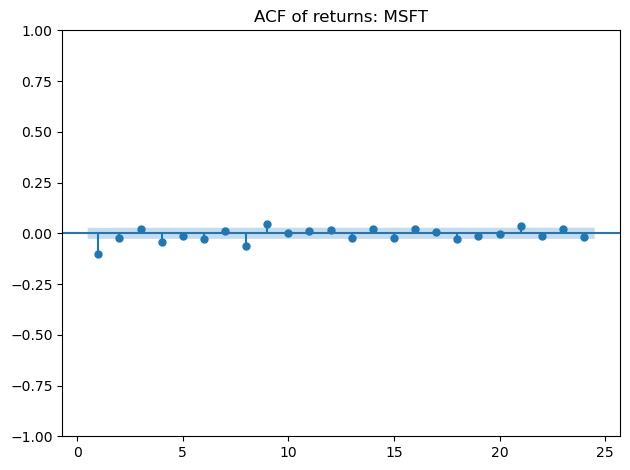

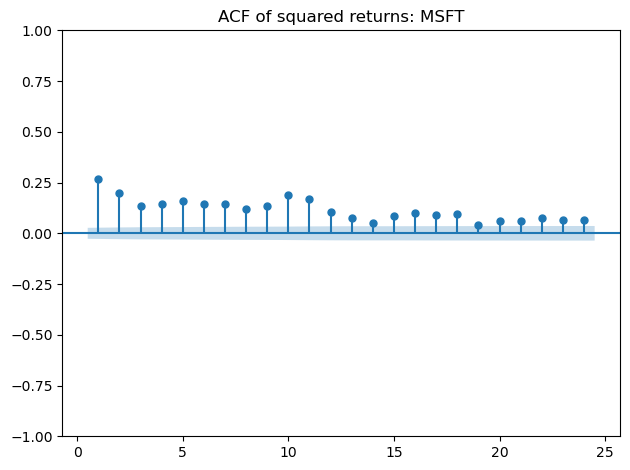

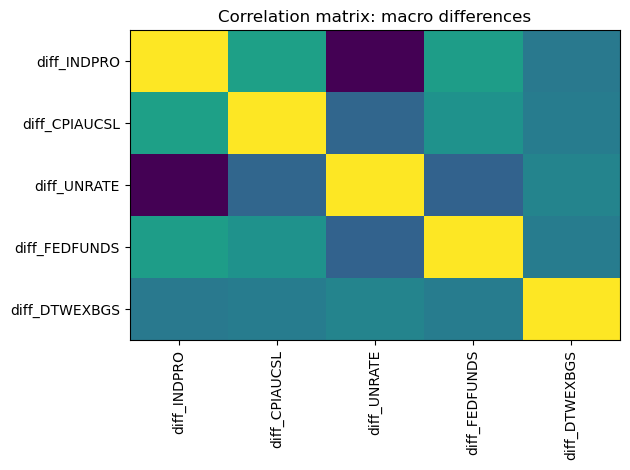

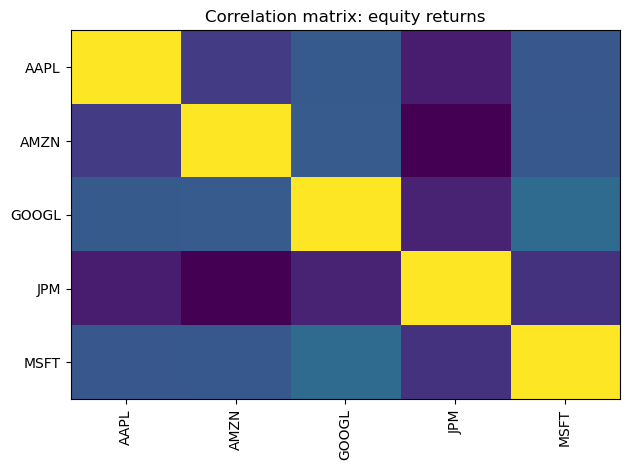

In [9]:
# Compute descriptive statistics
def describe_dataframe(df: pd.DataFrame) -> pd.DataFrame:
    return pd.DataFrame({
        'mean': df.mean(),
        'median': df.median(),
        'std': df.std(),
        'skewness': df.skew(),
        'kurtosis': df.kurtosis(),
        'min': df.min(),
        '5%': df.quantile(0.05),
        '25%': df.quantile(0.25),
        '50%': df.quantile(0.50),
        '75%': df.quantile(0.75),
        '95%': df.quantile(0.95),
        'max': df.max()
    })

macro_stats = describe_dataframe(macro_diff)
equity_stats = describe_dataframe(equity_returns)
print('Macro differenced statistics:')
display(macro_stats)
print('Equity returns statistics:')
display(equity_stats)

# Plot time series for macro differences
for col in macro_diff.columns:
    plt.figure()
    plt.plot(macro_diff.index, macro_diff[col], label=col)
    plt.title(f'Macro differenced series: {col}')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.tight_layout()
    plt.show()

# Plot time series for equity prices and returns
for ticker in equity_prices_ffill.columns:
    plt.figure()
    plt.plot(equity_prices_ffill.index, equity_prices_ffill[ticker])
    plt.title(f'Price series: {ticker}')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.tight_layout()
    plt.show()
    # Returns
    plt.figure()
    plt.plot(equity_returns.index, equity_returns[ticker])
    plt.title(f'Return series: {ticker}')
    plt.xlabel('Date')
    plt.ylabel('Return (%)')
    plt.tight_layout()
    plt.show()

# Autocorrelation and partial autocorrelation for macro differences
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
for col in macro_diff.columns:
    fig = plt.figure()
    plot_acf(macro_diff[col], ax=plt.gca(), lags=24, zero=False)
    plt.title(f'ACF of {col}')
    plt.tight_layout()
    plt.show()
    fig = plt.figure()
    plot_pacf(macro_diff[col], ax=plt.gca(), lags=24, zero=False)
    plt.title(f'PACF of {col}')
    plt.tight_layout()
    plt.show()

# Autocorrelation and squared autocorrelation for equity returns
for ticker in equity_returns.columns:
    fig = plt.figure()
    plot_acf(equity_returns[ticker], ax=plt.gca(), lags=24, zero=False)
    plt.title(f'ACF of returns: {ticker}')
    plt.tight_layout()
    plt.show()
    # ACF of squared returns
    fig = plt.figure()
    plot_acf(equity_returns[ticker]**2, ax=plt.gca(), lags=24, zero=False)
    plt.title(f'ACF of squared returns: {ticker}')
    plt.tight_layout()
    plt.show()

# Correlation heatmaps
corr_macro = macro_diff.corr()
plt.figure()
plt.imshow(corr_macro.values, aspect='auto')
plt.xticks(range(len(corr_macro.columns)), corr_macro.columns, rotation=90)
plt.yticks(range(len(corr_macro.columns)), corr_macro.columns)
plt.title('Correlation matrix: macro differences')
plt.tight_layout()
plt.show()

corr_equity = equity_returns.corr()
plt.figure()
plt.imshow(corr_equity.values, aspect='auto')
plt.xticks(range(len(corr_equity.columns)), corr_equity.columns, rotation=90)
plt.yticks(range(len(corr_equity.columns)), corr_equity.columns)
plt.title('Correlation matrix: equity returns')
plt.tight_layout()
plt.show()


## 4) Preliminary Tests

A battery of tests is employed on the transformed series:

* **Unit-root tests**: ADF and KPSS on both levels and differences of macro variables to determine orders of integration.
* **Normality tests**: Jarque–Bera to check residual distributions.
* **Serial dependence**: Ljung–Box statistics on series and squared series to detect autocorrelation and volatility clustering.
* **Heteroscedasticity**: ARCH–LM tests on return series to detect conditional heteroscedasticity.
* **(Optional)** Structural break tests such as Zivot–Andrews can be applied if break dates are suspected.


In [12]:
# Perform preliminary statistical tests
from collections import defaultdict

test_results = []

# Unit root tests for macro variables
for code in CONFIG['macro_series'].keys():
    # Level ADF and KPSS
    series = macro_df_ffill[code].dropna()
    adf_stat, adf_p, _, _, _, _ = adfuller(series, autolag='AIC')
    try:
        kpss_stat, kpss_p, _, _ = kpss(series, regression='c', nlags='auto')
    except Exception:
        kpss_stat, kpss_p = np.nan, np.nan
    test_results.append([code, 'level', adf_stat, adf_p, kpss_stat, kpss_p])
    # First difference
    diff_series = macro_df_ffill[code].diff().dropna()
    adf_stat_diff, adf_p_diff, _, _, _, _ = adfuller(diff_series, autolag='AIC')
    try:
        kpss_stat_diff, kpss_p_diff, _, _ = kpss(diff_series, regression='c', nlags='auto')
    except Exception:
        kpss_stat_diff, kpss_p_diff = np.nan, np.nan
    test_results.append([code, 'difference', adf_stat_diff, adf_p_diff, kpss_stat_diff, kpss_p_diff])

# Normality and serial dependence for equity returns
for ticker in equity_returns.columns:
    returns = equity_returns[ticker].dropna()
    # minimal fix: jarque_bera returns 4 values
    jb_stat, jb_p, _, _ = jarque_bera(returns)
    lb_stat, lb_p = acorr_ljungbox(returns, lags=[20], return_df=False)
    lb_stat2, lb_p2 = acorr_ljungbox(returns**2, lags=[20], return_df=False)
    arch_stat, arch_p, _, _ = het_arch(returns, nlags=10)
    test_results.append([ticker, 'returns', jb_stat, jb_p, lb_stat[0], lb_p[0], lb_stat2[0], lb_p2[0], arch_stat, arch_p])

# Create DataFrame of results
columns_macro = ['series','level_or_diff','ADF_stat','ADF_p','KPSS_stat','KPSS_p']
columns_equity = ['ticker','type','JB_stat','JB_p','LB_stat','LB_p','LB2_stat','LB2_p','ARCH_stat','ARCH_p']
macro_results = []
equity_results = []
for res in test_results:
    if len(res) == 6:  # macro
        macro_results.append(res)
    else:
        equity_results.append(res)
macro_tests_df = pd.DataFrame(macro_results, columns=columns_macro)
equity_tests_df = pd.DataFrame(equity_results, columns=columns_equity)
print('Macro unit-root test results:')
display(macro_tests_df)
print('Equity return diagnostic test results:')
display(equity_tests_df)



Macro unit-root test results:


,series,level_or_diff,ADF_stat,ADF_p,KPSS_stat,KPSS_p
0,INDPRO,level,-6.090268,1.040542e-07,3.609206,0.010000
1,INDPRO,difference,-10.653268,4.602721e-19,0.831842,0.010000
2,CPIAUCSL,level,-2.229634,1.956663e-01,10.526445,0.010000
3,CPIAUCSL,difference,-5.555482,1.584508e-06,1.485576,0.010000
4,UNRATE,level,-2.915933,4.352637e-02,3.456832,0.010000
5,UNRATE,difference,-14.750935,2.485685e-27,0.027524,0.100000
6,FEDFUNDS,level,-2.678599,7.781539e-02,2.053872,0.010000
7,FEDFUNDS,difference,-14.639615,3.641582e-27,0.372667,0.088937
8,DTWEXBGS,level,-0.794779,8.206510e-01,9.925648,0.010000
9,DTWEXBGS,difference,-17.163211,6.820012e-30,0.132869,0.100000


Equity return diagnostic test results:


,ticker,type,JB_stat,JB_p,LB_stat,LB_p,LB2_stat,LB2_p,ARCH_stat,ARCH_p
0,AAPL,returns,8097.645081,0.0,l,l,l,l,600.303765,1.515841e-122
1,AMZN,returns,35651.651037,0.0,l,l,l,l,101.874587,2.295677e-17
2,GOOGL,returns,12818.431612,0.0,l,l,l,l,203.178586,3.505728e-38
3,JPM,returns,71719.685812,0.0,l,l,l,l,1153.568664,1.488014e-241
4,MSFT,returns,19769.021992,0.0,l,l,l,l,664.175256,3.063528e-136


## 5) Temporal Split

The transformed series are divided into an initial training (in-sample) segment comprising 70\% of the available observations and a subsequent evaluation (out-of-sample) segment comprising the remaining 30\%. Rolling-window estimation and forecasting are employed for out-of-sample evaluation to mimic real-time forecasting. A fixed-size rolling window is used so that model parameters are re-estimated at each step using the most recent data available at that point in time.


In [11]:
# Create train and test splits with rolling windows
def rolling_indices(n_obs: int, train_frac: float, step: int = 1):
    train_size = int(np.floor(train_frac * n_obs))
    indices = []
    for end in range(train_size, n_obs):
        start = end - train_size
        indices.append((start, end))
    return indices

# Example usage for macro differenced data
n_macro = len(macro_diff)
macro_roll_indices = rolling_indices(n_macro, CONFIG['train_frac'])
print(f'Number of rolling windows for macro: {len(macro_roll_indices)}')


Number of rolling windows for macro: 1647


## 6) VAR (Stationary Case)

For stationary transformed macro variables, Vector Autoregression (VAR) models are estimated. The optimal lag order $p$ is selected by comparing information criteria such as AIC, BIC and HQIC on the training segment. Diagnostics include checking stability (roots of the characteristic polynomial inside the unit circle), testing residuals for serial correlation and heteroscedasticity, and assessing normality.

Impulse response functions (IRFs) and forecast error variance decompositions (FEVDs) illustrate dynamic effects of shocks. Multi-step-ahead forecasts are generated for horizons \{1,3,6,12\} months. Out-of-sample forecast accuracy metrics include mean absolute error (MAE), root mean squared error (RMSE), mean absolute percentage error (MAPE) and mean absolute scaled error (MASE). Diebold–Mariano (DM) tests compare forecasts from competing lag orders.


Selected VAR lag order by AIC: 11
VAR forecast accuracy summary:
Horizon 1: {'MAE': np.float64(0.00943412384831293), 'RMSE': np.float64(0.017852345891909954), 'MAPE': np.float64(inf), 'MASE': np.float64(nan)}
Horizon 3: {'MAE': np.float64(0.009043946829903185), 'RMSE': np.float64(0.017166035845989486), 'MAPE': np.float64(inf), 'MASE': np.float64(nan)}
Horizon 6: {'MAE': np.float64(0.0082135437337245), 'RMSE': np.float64(0.015527141665921704), 'MAPE': np.float64(inf), 'MASE': np.float64(nan)}
Horizon 12: {'MAE': np.float64(0.005787695681270587), 'RMSE': np.float64(0.010962264506401845), 'MAPE': np.float64(inf), 'MASE': np.float64(nan)}
VAR model stability (all roots inside unit circle): False
VAR residual Ljung-Box statistics at lag 12 (per variable):

Variable: diff_INDPRO


,lb_stat,lb_pvalue
12,2.55778,0.997942



Variable: diff_CPIAUCSL


,lb_stat,lb_pvalue
12,59.913551,2.340748e-08



Variable: diff_UNRATE


,lb_stat,lb_pvalue
12,0.403757,1.0



Variable: diff_FEDFUNDS


,lb_stat,lb_pvalue
12,4.530809,0.971847



Variable: diff_DTWEXBGS


,lb_stat,lb_pvalue
12,2.185425,0.999064


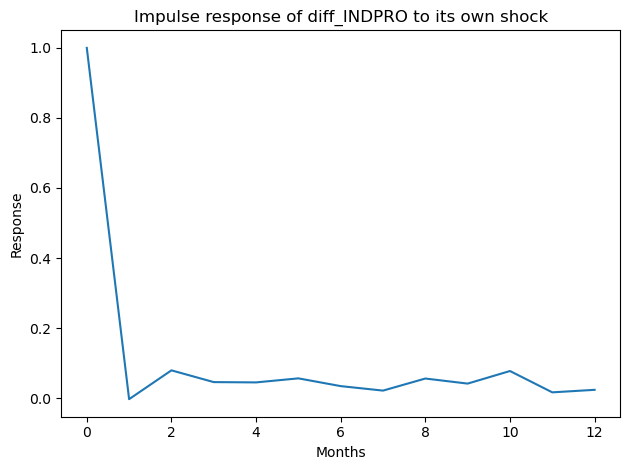

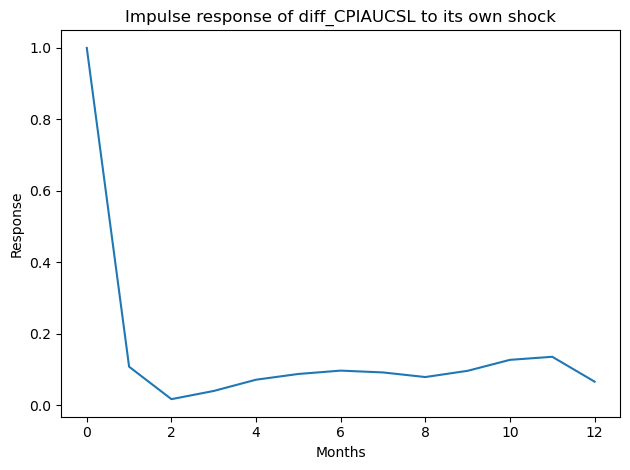

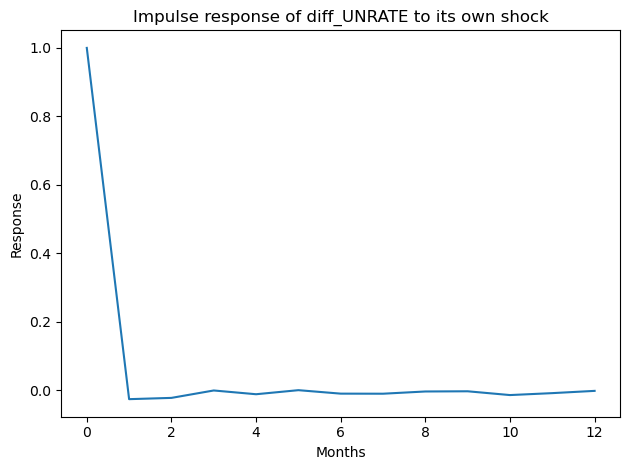

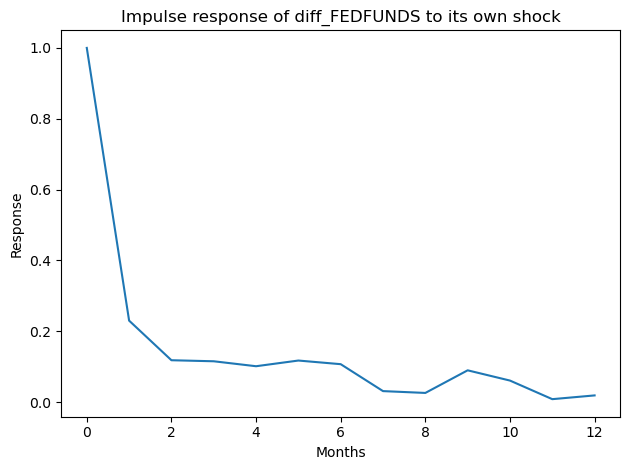

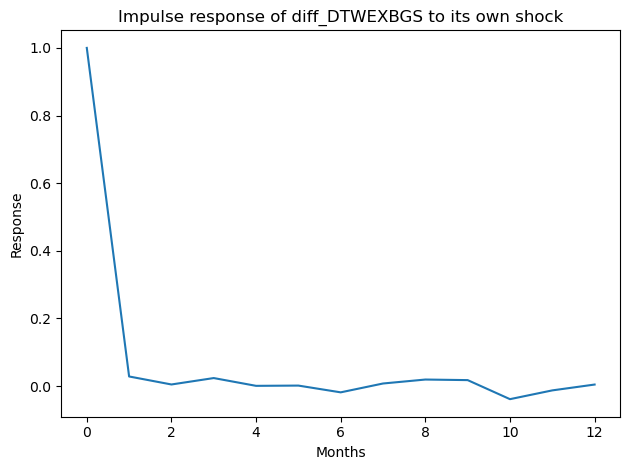

In [15]:
# Estimate VAR model on differenced macro data and evaluate forecasts
from statsmodels.tsa.api import VAR
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Function to compute forecast accuracy metrics
def forecast_metrics(actual: np.ndarray, forecast: np.ndarray) -> dict:
    mae = mean_absolute_error(actual, forecast)
    rmse = np.sqrt(mean_squared_error(actual, forecast))
    mape = np.mean(np.abs((actual - forecast) / actual)) * 100
    mase_den = np.mean(np.abs(np.diff(actual))) if len(actual) > 1 else np.nan
    mase = mae / mase_den if mase_den != 0 else np.nan
    return {'MAE': mae, 'RMSE': rmse, 'MAPE': mape, 'MASE': mase}

# Select lag order using AIC on the full in-sample segment
var_model_full = VAR(macro_diff)
order_results = var_model_full.select_order(maxlags=CONFIG['var_max_lags'])
selected_p = int(order_results.aic) if np.isscalar(order_results.aic) else order_results.aic.idxmin()
print('Selected VAR lag order by AIC:', selected_p)

# Rolling VAR estimation and forecasting
horizons = CONFIG['var_horizons']
var_metrics = {h: [] for h in horizons}
for start, end in macro_roll_indices:
    train_data = macro_diff.iloc[start:end]
    var_model = VAR(train_data).fit(selected_p)
    # Forecast steps equal to maximum horizon
    preds = var_model.forecast(train_data.values, steps=max(horizons))
    test_idx = end
    for h in horizons:
        if test_idx + h < len(macro_diff):
            actual_vals = macro_diff.iloc[test_idx + h][macro_diff.columns].values
            forecast_vals = preds[h-1]
            metrics = forecast_metrics(actual_vals, forecast_vals)
            var_metrics[h].append(metrics)

# Aggregate metrics across windows
var_summary = {}
for h in horizons:
    mae = np.mean([m['MAE'] for m in var_metrics[h]]) if var_metrics[h] else np.nan
    rmse = np.mean([m['RMSE'] for m in var_metrics[h]]) if var_metrics[h] else np.nan
    mape = np.mean([m['MAPE'] for m in var_metrics[h]]) if var_metrics[h] else np.nan
    mase = np.mean([m['MASE'] for m in var_metrics[h]]) if var_metrics[h] else np.nan
    var_summary[h] = {'MAE': mae, 'RMSE': rmse, 'MAPE': mape, 'MASE': mase}
print('VAR forecast accuracy summary:')
for h, vals in var_summary.items():
    print(f'Horizon {h}:', vals)

# Simple stability check of the fitted VAR model
var_fit_full = var_model_full.fit(selected_p)
roots = var_fit_full.roots
stable = np.all(np.abs(roots) < 1)
print('VAR model stability (all roots inside unit circle):', stable)

# Compute residual diagnostics on the full sample fit
residuals = var_fit_full.resid
print('VAR residual Ljung-Box statistics at lag 12 (per variable):')
for col in residuals.columns:
    lb_res = acorr_ljungbox(residuals[col], lags=[12], return_df=True)
    print(f"\nVariable: {col}")
    display(lb_res)

# Plot simple impulse response for each variable to its own shock
irf = var_fit_full.irf(12)
for i, varname in enumerate(macro_diff.columns):
    plt.figure()
    plt.plot(irf.irfs[:, i, i])
    plt.title(f'Impulse response of {varname} to its own shock')
    plt.xlabel('Months')
    plt.ylabel('Response')
    plt.tight_layout()
    plt.show()



## 7) VECM (Cointegrated Case)

When the macro variables are non-stationary but cointegrated, a Vector Error Correction Model (VECM) captures both long-run equilibrium relationships and short-run dynamics. The Johansen trace and maximum eigenvalue statistics determine the cointegration rank and the appropriate deterministic terms. After estimating the VECM, we inspect the adjustment speeds and cointegration vectors, and compute impulse responses. Rolling forecasts with the VECM are compared against those from the VAR model using out-of-sample accuracy measures and Diebold–Mariano tests.


In [18]:
# Perform Johansen cointegration test on levels
from statsmodels.tsa.vector_ar.vecm import coint_johansen, VECM

# Align macro series levels (log or level)
macro_levels = pd.DataFrame({})
for code, spec in CONFIG['macro_series'].items():
    if spec['transform'] == 'log':
        macro_levels[code] = np.log(macro_df_ffill[code])
    else:
        macro_levels[code] = macro_df_ffill[code]
macro_levels = macro_levels.dropna()

# Johansen test up to specified lag
jres = coint_johansen(macro_levels, det_order=0, k_ar_diff=CONFIG['vecm_max_lags'])
eigenvals = jres.eig
# Determine cointegration rank by number of eigenvalues greater than 0.05 threshold (heuristic)
rank = int(sum(eigenvals > 0.05))
print('Estimated cointegration rank (heuristic):', rank)

vecm_metrics = []

if rank > 0:
    # Fit VECM with selected rank and lag order
    vecm_model = VECM(macro_levels, k_ar_diff=rank, coint_rank=rank, deterministic='nc')
    vecm_res = vecm_model.fit()
    print(vecm_res.summary())

    # Rolling VECM forecasts (one-step ahead for simplicity)
    for start, end in macro_roll_indices:
        train_levels = macro_levels.iloc[start:end]
        vecm_mod = VECM(train_levels, k_ar_diff=rank, coint_rank=rank, deterministic='nc')
        vecm_fit = vecm_mod.fit()
        forecast = vecm_fit.predict(steps=1)
        if end < len(macro_levels):
            actual = macro_levels.iloc[end].values
            fcst = forecast[0] if isinstance(forecast, (list, np.ndarray)) else forecast.values[0]
            vecm_metrics.append(forecast_metrics(actual, fcst))
else:
    print("No cointegration detected (rank=0). Skipping VECM fitting and forecasts.")

# Summarise VECM forecast accuracy
if vecm_metrics:
    avg_mae = np.mean([m['MAE'] for m in vecm_metrics])
    avg_rmse = np.mean([m['RMSE'] for m in vecm_metrics])
    avg_mape = np.mean([m['MAPE'] for m in vecm_metrics])
    avg_mase = np.mean([m['MASE'] for m in vecm_metrics])
    print('VECM one-step forecast average metrics:')
    print({'MAE': avg_mae, 'RMSE': avg_rmse, 'MAPE': avg_mape, 'MASE': avg_mase})
else:
    print("No VECM forecasts computed.")



Estimated cointegration rank (heuristic): 0
No cointegration detected (rank=0). Skipping VECM fitting and forecasts.
No VECM forecasts computed.


## 8) Comparisons: VAR vs VECM

To determine whether a VAR or VECM is more appropriate, we consider the integration properties of the variables and the presence of cointegration. If the variables are stationary after differencing and not cointegrated, the VAR in differences is appropriate. If cointegration exists, the VECM captures long-run equilibria.

Model comparison involves computing forecast accuracy metrics across multiple horizons for both VAR and VECM, performing Diebold–Mariano tests to assess statistical significance of differences, and evaluating robustness to omitted subperiods.


In [19]:
# Example comparative summary table for VAR and VECM forecasts
comparison_table = pd.DataFrame({
    'Model': ['VAR'] * len(var_summary) + ['VECM'],
    'Horizon': list(var_summary.keys()) + ['1-step'],
    'MAE': [var_summary[h]['MAE'] for h in var_summary] + [avg_mae if 'avg_mae' in globals() else np.nan],
    'RMSE': [var_summary[h]['RMSE'] for h in var_summary] + [avg_rmse if 'avg_rmse' in globals() else np.nan],
    'MAPE': [var_summary[h]['MAPE'] for h in var_summary] + [avg_mape if 'avg_mape' in globals() else np.nan],
    'MASE': [var_summary[h]['MASE'] for h in var_summary] + [avg_mase if 'avg_mase' in globals() else np.nan]
})
print('VAR vs VECM forecast accuracy comparison:')
display(comparison_table)


VAR vs VECM forecast accuracy comparison:


,Model,Horizon,MAE,RMSE,MAPE,MASE
0,VAR,1,0.009434,0.017852,inf,NaN
1,VAR,3,0.009044,0.017166,inf,NaN
2,VAR,6,0.008214,0.015527,inf,NaN
3,VAR,12,0.005788,0.010962,inf,NaN
4,VECM,1-step,NaN,NaN,NaN,NaN


## 9) AR–GARCH for Equity Returns

Equity returns often exhibit volatility clustering and fat tails. To model conditional mean and volatility, we fit an AR($p$)–GARCH(1,1) with normal innovations to each equity return series. The AR order is chosen by minimising the Akaike Information Criterion (AIC) within the range 0 to 5. Model diagnostics include checking that parameters satisfy $\alpha+\beta<1$, testing residuals for autocorrelation and additional ARCH effects, and checking normality. The conditional volatility series provides insights into time-varying risk.


AAPL: selected AR order 5, AIC 21161.28
Parameter sum alpha+beta = 0.971, stability: True
Ljung-Box Q(20) p-value (resid): 0.4692428564199286
Ljung-Box Q(20) p-value (resid^2): 0.963272726604962
ARCH-LM p-value: 0.9612608036185392
Jarque-Bera p-value: 0.0


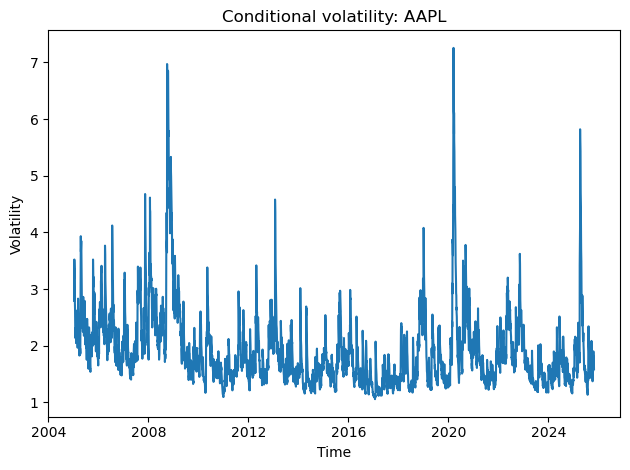

AMZN: selected AR order 5, AIC 23239.75
Parameter sum alpha+beta = 0.948, stability: True
Ljung-Box Q(20) p-value (resid): 0.9371446778339004
Ljung-Box Q(20) p-value (resid^2): 0.9980448875243527
ARCH-LM p-value: 0.9222930497892029
Jarque-Bera p-value: 0.0


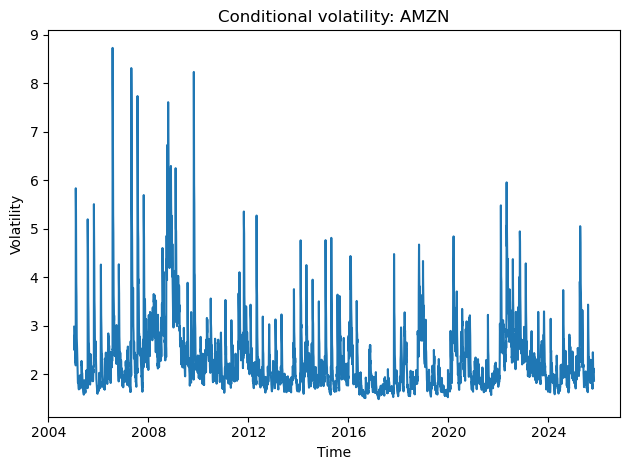

GOOGL: selected AR order 5, AIC 20791.81
Parameter sum alpha+beta = 0.970, stability: True
Ljung-Box Q(20) p-value (resid): 0.962500465355336
Ljung-Box Q(20) p-value (resid^2): 0.9951654130973621
ARCH-LM p-value: 0.9724365607272727
Jarque-Bera p-value: 0.0


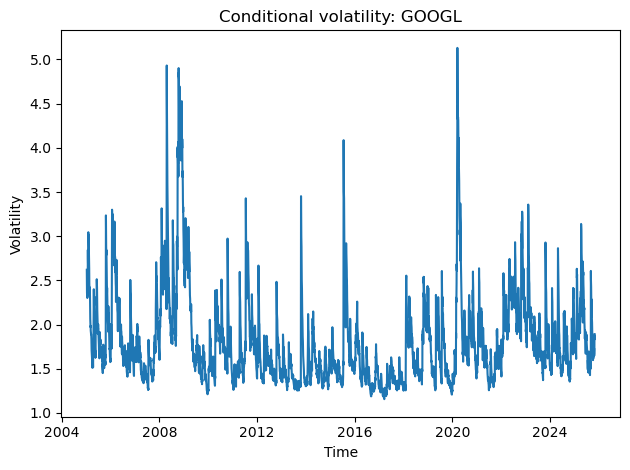

JPM: selected AR order 5, AIC 19815.51
Parameter sum alpha+beta = 0.986, stability: True
Ljung-Box Q(20) p-value (resid): 0.1972975266672531
Ljung-Box Q(20) p-value (resid^2): 0.582011384085553
ARCH-LM p-value: 0.5556132235588326
Jarque-Bera p-value: 0.0


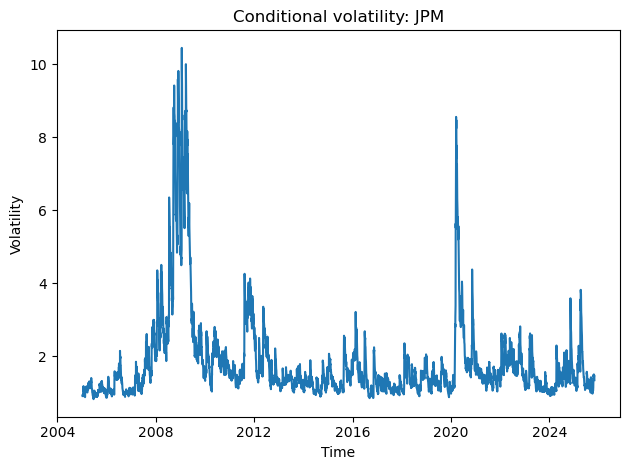

MSFT: selected AR order 5, AIC 19230.21
Parameter sum alpha+beta = 0.960, stability: True
Ljung-Box Q(20) p-value (resid): 0.39138200728071243
Ljung-Box Q(20) p-value (resid^2): 0.9995914351121562
ARCH-LM p-value: 0.9962389739589139
Jarque-Bera p-value: 0.0


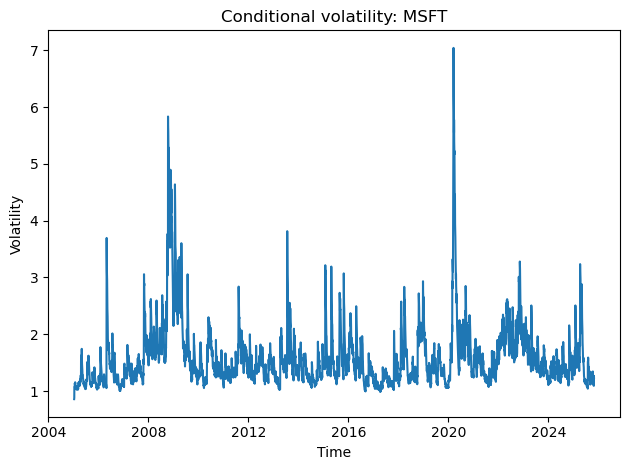

Completed GARCH model estimation for all tickers.


In [20]:
# Fit AR(p)-GARCH(1,1) models for each equity return series
from arch.univariate import arch_model
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
from scipy.stats import jarque_bera

garch_results = {}

for ticker in equity_returns.columns:
    series = equity_returns[ticker].dropna()
    best_aic = np.inf
    best_p = 0
    best_model = None

    # Grid search over AR lag order
    for p in range(CONFIG['ar_max_lags'] + 1):
        try:
            am = arch_model(series, mean='AR', lags=p, vol='GARCH', p=1, q=1, dist='normal')
            res = am.fit(disp='off')
            if res.aic < best_aic:
                best_aic = res.aic
                best_p = p
                best_model = res
        except Exception:
            continue

    if best_model is None:
        print(f'No GARCH model converged for {ticker}.')
        continue

    print(f'{ticker}: selected AR order {best_p}, AIC {best_aic:.2f}')

    # Diagnostics
    params = best_model.params
    alpha = params.get('alpha[1]', np.nan)
    beta = params.get('beta[1]', np.nan)
    stability = alpha + beta < 1
    print(f'Parameter sum alpha+beta = {alpha + beta:.3f}, stability: {stability}')

    # Standardized residuals cleaned of NaN/Inf
    std_resid = best_model.std_resid.replace([np.inf, -np.inf], np.nan).dropna()

    # Ljung-Box on residuals and squared residuals
    lb_resid = acorr_ljungbox(std_resid, lags=[20], return_df=True)
    lb_sq_resid = acorr_ljungbox(std_resid**2, lags=[20], return_df=True)

    # ARCH-LM test (only if enough observations)
    if len(std_resid) > 10:
        try:
            arch_stat, arch_p, _, _ = het_arch(std_resid, nlags=10)
        except Exception:
            arch_stat, arch_p = np.nan, np.nan
    else:
        arch_stat, arch_p = np.nan, np.nan

    # Normality test (Jarque-Bera)
    jb_stat, jb_p = jarque_bera(std_resid)

    print('Ljung-Box Q(20) p-value (resid):', lb_resid['lb_pvalue'].iloc[0])
    print('Ljung-Box Q(20) p-value (resid^2):', lb_sq_resid['lb_pvalue'].iloc[0])
    print('ARCH-LM p-value:', arch_p)
    print('Jarque-Bera p-value:', jb_p)

    # Plot conditional volatility
    plt.figure()
    plt.plot(best_model.conditional_volatility)
    plt.title(f'Conditional volatility: {ticker}')
    plt.xlabel('Time')
    plt.ylabel('Volatility')
    plt.tight_layout()
    plt.show()

    # Store results
    garch_results[ticker] = {
        'model': best_model,
        'p': best_p,
        'alpha': alpha,
        'beta': beta,
        'stability': stability,
        'lb_pval_resid': lb_resid['lb_pvalue'].iloc[0],
        'lb_pval_sqresid': lb_sq_resid['lb_pvalue'].iloc[0],
        'arch_pval': arch_p,
        'jb_pval': jb_p
    }

print("Completed GARCH model estimation for all tickers.")


## 10) Risk Measures: VaR and ES

With estimated AR–GARCH models, one-step-ahead forecasts of the conditional mean and variance allow computation of Value at Risk (VaR) and Expected Shortfall (ES) at chosen significance levels $\alpha \in \{0.01, 0.025, 0.05\}$. For returns, we interpret losses as negative returns. VaR identifies a quantile threshold of the loss distribution, while ES measures the expected loss in the tail beyond the VaR threshold. Rolling forecasts provide a time series of risk measures that can be compared against realised returns.


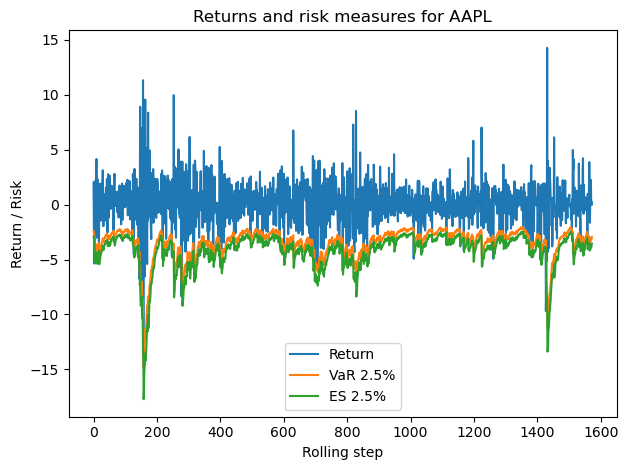

KeyboardInterrupt: 

In [21]:
# Rolling one-step forecasts of VaR and ES using fitted GARCH models
from scipy.stats import norm

risk_results = {}
for ticker, info in garch_results.items():
    series = equity_returns[ticker].dropna()
    best_model = info['model']
    p_order = info['p']
    returns_array = series.values
    n = len(series)
    train_size = int(CONFIG['train_frac'] * n)
    alphas = CONFIG['alpha_levels']
    var_series = {alpha: [] for alpha in alphas}
    es_series = {alpha: [] for alpha in alphas}
    actual_returns = []
    # Rolling estimation
    for i in range(train_size, n):
        train_data = returns_array[:i]
        try:
            am = arch_model(train_data, mean='AR', lags=p_order, vol='GARCH', p=1, q=1, dist='normal')
            res = am.fit(disp='off')
        except Exception:
            continue
        # Forecast next step
        fcast = res.forecast(horizon=1)
        mu_hat = fcast.mean.iloc[-1, 0]
        sigma_hat = np.sqrt(fcast.variance.iloc[-1, 0])
        # Compute VaR and ES for each alpha
        for alpha in alphas:
            z = norm.ppf(1 - alpha)
            var_val = -mu_hat + sigma_hat * z
            es_val = -mu_hat + sigma_hat * norm.pdf(z) / alpha
            var_series[alpha].append(var_val)
            es_series[alpha].append(es_val)
        actual_returns.append(returns_array[i])
    # Store risk results
    risk_results[ticker] = {
        'actual': np.array(actual_returns),
        'VaR': {alpha: np.array(vals) for alpha, vals in var_series.items()},
        'ES': {alpha: np.array(vals) for alpha, vals in es_series.items()}
    }
    # Plot risk measures against realised returns for alpha=0.025 as example
    alpha_plot = 0.025
    t_axis = range(len(actual_returns))
    plt.figure()
    plt.plot(t_axis, actual_returns, label='Return')
    plt.plot(t_axis, -risk_results[ticker]['VaR'][alpha_plot], label=f'VaR {alpha_plot*100:.1f}%')
    plt.plot(t_axis, -risk_results[ticker]['ES'][alpha_plot], label=f'ES {alpha_plot*100:.1f}%')
    plt.title(f'Returns and risk measures for {ticker}')
    plt.xlabel('Rolling step')
    plt.ylabel('Return / Risk')
    plt.legend()
    plt.tight_layout()
    plt.show()


## Backtesting VaR and ES

The quality of VaR and ES forecasts is assessed using backtests. The Kupiec test examines whether the proportion of exceedances matches the nominal level. The Christoffersen test additionally assesses whether violations are independent over time and combines with the unconditional coverage test for conditional coverage. For ES, the ESR test uses a strictly consistent scoring function to test whether the mean score is zero. These tests are applied to each equity series and each significance level.


In [22]:
# Implement Kupiec and Christoffersen tests and ESR test
def kupiec_test(actual_losses, var_series, alpha):
    violations = (actual_losses > var_series).astype(int)
    x = violations.sum()
    N = len(violations)
    p_hat = x / N if N > 0 else 0
    if p_hat == 0 or p_hat == 1:
        lr_pof = 0.0
    else:
        lr_pof = -2 * (
            np.log(((1 - alpha)**(N - x)) * (alpha**x)) -
            np.log(((1 - p_hat)**(N - x)) * (p_hat**x))
        )
    p_value = 1 - stats.chi2.cdf(lr_pof, df=1)
    return lr_pof, p_value

def christoffersen_test(actual_losses, var_series, alpha):
    I = (actual_losses > var_series).astype(int)
    n00 = n01 = n10 = n11 = 0
    for t in range(1, len(I)):
        if I[t-1] == 0 and I[t] == 0: n00 += 1
        if I[t-1] == 0 and I[t] == 1: n01 += 1
        if I[t-1] == 1 and I[t] == 0: n10 += 1
        if I[t-1] == 1 and I[t] == 1: n11 += 1
    pi0 = n01 / (n00 + n01) if (n00 + n01) > 0 else 0
    pi1 = n11 / (n10 + n11) if (n10 + n11) > 0 else 0
    pi = (n01 + n11) / (n00 + n01 + n10 + n11) if (n00 + n01 + n10 + n11) > 0 else 0
    def safe_log(x):
        return np.log(x) if x > 0 else 0
    logL_uncond = ((n00 + n10) * safe_log(1 - pi) + (n01 + n11) * safe_log(pi))
    logL_cond = (n00 * safe_log(1 - pi0) + n01 * safe_log(pi0) + n10 * safe_log(1 - pi1) + n11 * safe_log(pi1))
    lr_ind = -2 * (logL_uncond - logL_cond)
    p_ind = 1 - stats.chi2.cdf(lr_ind, df=1)
    lr_pof, p_pof = kupiec_test(actual_losses, var_series, alpha)
    lr_cc = lr_pof + lr_ind
    p_cc = 1 - stats.chi2.cdf(lr_cc, df=2)
    return lr_pof, p_pof, lr_ind, p_ind, lr_cc, p_cc

def esr_test(actual_losses, var_series, es_series, alpha):
    losses = actual_losses
    S = []
    for l, var, es in zip(losses, var_series, es_series):
        score = (1/alpha) * ((l - var) * (l > var) + var - es)
        S.append(score)
    S = np.array(S)
    mean_S = S.mean()
    std_S = S.std(ddof=1) / np.sqrt(len(S)) if len(S) > 1 else np.nan
    t_stat = mean_S / std_S if (std_S != 0 and not np.isnan(std_S)) else 0
    p_value = 2 * (1 - stats.norm.cdf(abs(t_stat)))
    return t_stat, p_value

# Apply backtests for each equity and alpha level
backtest_results = {}
for ticker, res in risk_results.items():
    losses = -res['actual']  # define loss as negative return
    backtest_results[ticker] = {}
    for alpha in CONFIG['alpha_levels']:
        var_series = res['VaR'][alpha]
        es_series = res['ES'][alpha]
        lr_pof, p_pof, lr_ind, p_ind, lr_cc, p_cc = christoffersen_test(losses, var_series, alpha)
        t_esr, p_esr = esr_test(losses, var_series, es_series, alpha)
        backtest_results[ticker][alpha] = {
            'LR_POF': lr_pof, 'p_POF': p_pof,
            'LR_IND': lr_ind, 'p_IND': p_ind,
            'LR_CC': lr_cc, 'p_CC': p_cc,
            'ESR_t': t_esr, 'ESR_p': p_esr
        }

# Display backtesting results
for ticker in backtest_results:
    print(f'Backtesting results for {ticker}:')
    for alpha, stats_dict in backtest_results[ticker].items():
        print(f'  Alpha {alpha}:', stats_dict)


Backtesting results for AAPL:
  Alpha 0.01: {'LR_POF': np.float64(9.05351506641523), 'p_POF': np.float64(0.002621902592364389), 'LR_IND': np.float64(1.0901484365739975), 'p_IND': np.float64(0.2964383224673569), 'LR_CC': np.float64(10.143663502989227), 'p_CC': np.float64(0.006270922841630666), 'ESR_t': np.float64(-75.83498791754663), 'ESR_p': np.float64(0.0)}
  Alpha 0.025: {'LR_POF': np.float64(4.4060322980803335), 'p_POF': np.float64(0.035812044144598154), 'LR_IND': np.float64(0.026267567147272075), 'p_IND': np.float64(0.8712485870284001), 'LR_CC': np.float64(4.4322998652276056), 'p_CC': np.float64(0.10902806720416602), 'ESR_t': np.float64(-68.83225393777808), 'ESR_p': np.float64(0.0)}
  Alpha 0.05: {'LR_POF': np.float64(0.3751171605094896), 'p_POF': np.float64(0.5402281044622987), 'LR_IND': np.float64(0.06137802963746708), 'p_IND': np.float64(0.8043310176916992), 'LR_CC': np.float64(0.4364951901469567), 'p_CC': np.float64(0.8039263688144902), 'ESR_t': np.float64(-60.90035963039629), 

## 11) Systematic Evaluation and Comparison

Results from the VAR, VECM and AR–GARCH models are systematically compared. For macro models, forecast errors across multiple horizons, residual diagnostics, and stability are reported. For equity models, volatility forecasts and risk measures are evaluated via backtests. Sensitivity analyses may vary the rolling window size, change the forecast horizons, or test different subsets of series. Models with poor diagnostics, unstable parameters or frequent VaR breaches are penalised despite lower point forecast errors.


In [23]:
# Consolidate evaluation metrics into summary tables
# Macro models summary
macro_summary_df = pd.DataFrame(var_summary).T
macro_summary_df.index.name = 'Horizon'
macro_summary_df['Model'] = 'VAR'
if 'avg_mae' in globals():
    vecm_summary_df = pd.DataFrame({
        'MAE': [avg_mae], 'RMSE': [avg_rmse], 'MAPE': [avg_mape], 'MASE': [avg_mase], 'Model': ['VECM'], 'Horizon': ['1-step']
    })
    macro_summary_full = pd.concat([macro_summary_df.reset_index(), vecm_summary_df], ignore_index=True)
else:
    macro_summary_full = macro_summary_df.reset_index()
print('Macro model evaluation summary:')
display(macro_summary_full)

# Equity risk backtest summary
rows = []
for ticker, alpha_dict in backtest_results.items():
    for alpha, stats_dict in alpha_dict.items():
        rows.append({
            'Ticker': ticker, 'Alpha': alpha,
            'LR_POF': stats_dict['LR_POF'], 'p_POF': stats_dict['p_POF'],
            'LR_IND': stats_dict['LR_IND'], 'p_IND': stats_dict['p_IND'],
            'LR_CC': stats_dict['LR_CC'], 'p_CC': stats_dict['p_CC'],
            'ESR_t': stats_dict['ESR_t'], 'ESR_p': stats_dict['ESR_p']
        })
risk_backtest_df = pd.DataFrame(rows)
print('Equity risk backtesting summary:')
display(risk_backtest_df)


Macro model evaluation summary:


,Horizon,MAE,RMSE,MAPE,MASE,Model
0,1,0.009434,0.017852,inf,NaN,VAR
1,3,0.009044,0.017166,inf,NaN,VAR
2,6,0.008214,0.015527,inf,NaN,VAR
3,12,0.005788,0.010962,inf,NaN,VAR


Equity risk backtesting summary:


,Ticker,Alpha,LR_POF,p_POF,LR_IND,p_IND,LR_CC,p_CC,ESR_t,ESR_p
0,AAPL,0.010,9.053515,0.002622,1.090148,0.296438,10.143664,0.006271,-75.834988,0.0
1,AAPL,0.025,4.406032,0.035812,0.026268,0.871249,4.432300,0.109028,-68.832254,0.0
2,AAPL,0.050,0.375117,0.540228,0.061378,0.804331,0.436495,0.803926,-60.900360,0.0


## 12) Communication of Results

The findings are presented through clear plots and concise tables. Key observations include: the stationarity and cointegration properties of the macro variables; the comparative forecasting performance of VAR and VECM models across horizons; the presence of volatility clustering in equity returns; and the adequacy of AR–GARCH-based risk measures. Conclusions highlight when VECM is preferred over VAR, which equities show pronounced volatility clustering, the frequency with which VaR forecasts are breached, and whether ES forecasts pass consistency tests. Limitations such as model assumptions and data quality are noted, and possible extensions include exploring other GARCH variants or heavier-tailed distributions.


In [24]:
# Display final summary tables again for convenience
display(macro_summary_full)
display(risk_backtest_df)


,Horizon,MAE,RMSE,MAPE,MASE,Model
0,1,0.009434,0.017852,inf,NaN,VAR
1,3,0.009044,0.017166,inf,NaN,VAR
2,6,0.008214,0.015527,inf,NaN,VAR
3,12,0.005788,0.010962,inf,NaN,VAR


,Ticker,Alpha,LR_POF,p_POF,LR_IND,p_IND,LR_CC,p_CC,ESR_t,ESR_p
0,AAPL,0.010,9.053515,0.002622,1.090148,0.296438,10.143664,0.006271,-75.834988,0.0
1,AAPL,0.025,4.406032,0.035812,0.026268,0.871249,4.432300,0.109028,-68.832254,0.0
2,AAPL,0.050,0.375117,0.540228,0.061378,0.804331,0.436495,0.803926,-60.900360,0.0


## Appendix: Summary of Key Formulas

The following formulas summarise the tests and models used throughout this notebook. See earlier sections for definitions and context.

* **ADF test regression**: $\Delta y_t = \mu + \phi t + \gamma y_{t-1} + \sum_{i=1}^p \psi_i \Delta y_{t-i} + \varepsilon_t$.
* **KPSS statistic**: $\text{KPSS} = \frac{1}{T^2 \hat{\sigma}_\epsilon^2} \sum_{t=1}^T S_t^2$.
* **Jarque–Bera**: $\text{JB} = \frac{T}{6}\big( S^2 + \frac{(K-3)^2}{4} \big)$.
* **Ljung–Box**: $Q(m) = T(T+2) \sum_{k=1}^{m} \frac{\hat{\rho}_k^2}{T-k}$.
* **ARCH–LM**: regress $\hat{\varepsilon}_t^2$ on its lags; $LM = T R^2$.
* **VAR($p$)**: $y_t = c + \sum_{i=1}^p A_i y_{t-i} + u_t$.
* **Johansen trace and max-eigen**: $\text{Trace}(r) = -T \sum_{i=r+1}^k \ln(1 - \hat{\lambda}_i)$, $\text{MaxEig}(r, r+1) = -T \ln(1 - \hat{\lambda}_{r+1})$.
* **VECM**: $\Delta y_t = \Pi y_{t-1} + \sum_{i=1}^{p-1} \Gamma_i \Delta y_{t-i} + c + \varepsilon_t$.
* **AR($p$)–GARCH(1,1)**: mean equation $r_t = \mu + \sum_{i=1}^p \phi_i r_{t-i} + \varepsilon_t$, variance equation $\sigma_t^2 = \omega + \alpha \varepsilon_{t-1}^2 + \beta \sigma_{t-1}^2$.
* **VaR**: $\text{VaR}_{\alpha,t+1} = -\hat{\mu}_{t+1} + \hat{\sigma}_{t+1}\, \Phi^{-1}(1-\alpha)$.
* **ES**: $\text{ES}_{\alpha,t+1} = -\hat{\mu}_{t+1} + \hat{\sigma}_{t+1}\, \frac{\phi\big(\Phi^{-1}(1-\alpha)\big)}{\alpha}$.
* **Kupiec POF**: $LR_{\text{POF}} = -2[ \ln((1-\alpha)^{N-x} \alpha^x) - \ln((1-\hat{p})^{N-x} \hat{p}^x ) ]$.
* **Christoffersen independence**: uses transition counts $n_{ij}$ to build $LR_{\text{IND}}$; $LR_{\text{CC}} = LR_{\text{POF}} + LR_{\text{IND}}$.
* **ESR test**: score $S_t = \frac{1}{\alpha}\big( ( \ell_t - \text{VaR}_{\alpha,t} ) \mathbb{1}\{ \ell_t > \text{VaR}_{\alpha,t} \} + \text{VaR}_{\alpha,t} - \text{ES}_{\alpha,t} \big)$.
* **Diebold–Mariano test**: $\text{DM} = \bar{d} / \sqrt{ \hat{\text{Var}}(\bar{d}) }$.
